In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
from tqdm import tqdm
import json
import pandas as pd
from scipy.stats import beta
from scipy.stats import cramervonmises, kstest
from tqdm.auto import tqdm


anduryl_dir = Path("d:/Documents/GitHub/anduryl")
sys.path.append(str(anduryl_dir))
import anduryl
from anduryl.io.settings import CalculationSettings, CalibrationMethod, Distribution
from anduryl.core import crps

In [2]:
with open("Results/sampled_sa_scores.json", "r") as f:
    sa_scores = json.load(f)

with open("Results/sampled_sa_scores_extra.json", "r") as f:
    sa_scores_extra = json.load(f)
    for key in sa_scores.keys():
        sa_scores[key]['Overconfident'] = sa_scores_extra[key]['Overconfident 2']

In [8]:
experts = {
    "Perfectly calibrated": (1, 1),
    "Overconfident": (0.35, 0.35),
    "Underconfident": (2, 2),
    "Location-biased": (1, 2),
}

sa_methods = [
    CalibrationMethod.Chi2,
    CalibrationMethod.CRPS,
    CalibrationMethod.KS,
    CalibrationMethod.CVM,
    CalibrationMethod.AD,
    #     CalibrationMethod.SW,
]

N = 50
minN = 3

offset = 2

npoints = list(range(3, N + 1))[offset:]

In [9]:
def add_beta_plot(name, ax):
    a, b = experts[name]
    dist = beta(a, b)
    x = np.linspace(0, 1, 101)
    ax.plot(x, dist.pdf(x), color=".1", lw=0.65)
    ax.fill_between(x, dist.pdf(x), y2=0.0, alpha=0.1, color=".1")
    ps = [0.05, 0.5, 0.95]
    for p in ps:
        ax.axvline(p, color=".1", ls=":",lw=1)
    allps = np.r_[0.0, ps, 1.0]
    mids = (allps[1:] + allps[:-1]) / 2
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 3)

    ax.axhline(0.0, color=".6", ls="-")

    for m, prob in zip(mids, np.diff(dist.cdf(allps))):
        ax.text(m, np.mean(ax.get_ylim()), f"{prob:.2f}", ha="center", rotation=90, va='center')
        print(prob)
    ax.set_title(f"{name} - beta({a}, {b})",fontsize=9)

    for spine in ax.spines.values():
        spine.set_visible(False)

In [10]:
# fig = plt.figure(figsize=(20, 10))

# for j, name in enumerate(experts.keys()):
#     # Add betaplot
#     ax = plt.subplot2grid((len(sa_methods)+1, len(experts)*2), (0, j*2), rowspan=1, colspan=2, fig=fig)
#     add_beta_plot(name, ax)

# for i, method in enumerate(sa_methods):

#     method_res = sa_scores[method.value]

#     for j, (name, cali_res) in enumerate(method_res.items()):

#         # Add other plots
#         axrow = [
#             plt.subplot2grid((len(sa_methods)+1, len(experts)*2), (i+1, j*2), fig=fig),
#             plt.subplot2grid((len(sa_methods)+1, len(experts)*2), (i+1, j*2+1), fig=fig)
#         ]

#         for ax in axrow:
#             ax.fill_between(npoints, *np.percentile(cali_res, [2.5, 25], axis=0), alpha=0.15, label='95% ival', color=f'C{i}', lw=0)
#             ax.fill_between(npoints, *np.percentile(cali_res, [25, 75], axis=0), alpha=0.3, label='50% ival', color=f'C{i}', lw=0)
#             ax.fill_between(npoints, *np.percentile(cali_res, [75, 97.5], axis=0), alpha=0.15, color=f'C{i}', lw=0)
#             ax.plot(npoints, *np.percentile(cali_res, [50], axis=0), alpha=0.5, label='Median', color=f'C{i}')
#             ax.plot(npoints, np.mean(cali_res, axis=0), alpha=0.5, label='Mean', color=f'C{i}', ls='--')
#             ax.grid()

#         if j == 4:
#             axrow[1].legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
# #         if j == 0:
# #             axrow[0].set_ylabel('Statistical\naccuracy')

#         axrow[0].set_ylim(0, 1)
#         axrow[0].set_ylabel(method.value+' (SA)')
#         axrow[1].set_yscale('log')
#         axrow[1].set_ylim(1e-4, 1)

# fig.tight_layout()

# fig.savefig('./figures/sampling_res_full.pdf')

In [11]:
from hkvpy import plotting
plotting.set_rcparams()

0.05
0.45
0.44999999999999996
0.050000000000000044
0.20222296237990298
0.2977770376200969
0.297777037620097
0.20222296237990312
0.007250000000000001
0.49275
0.49275
0.007249999999999979
0.09749999999999999
0.6525
0.24749999999999994
0.0025000000000000577


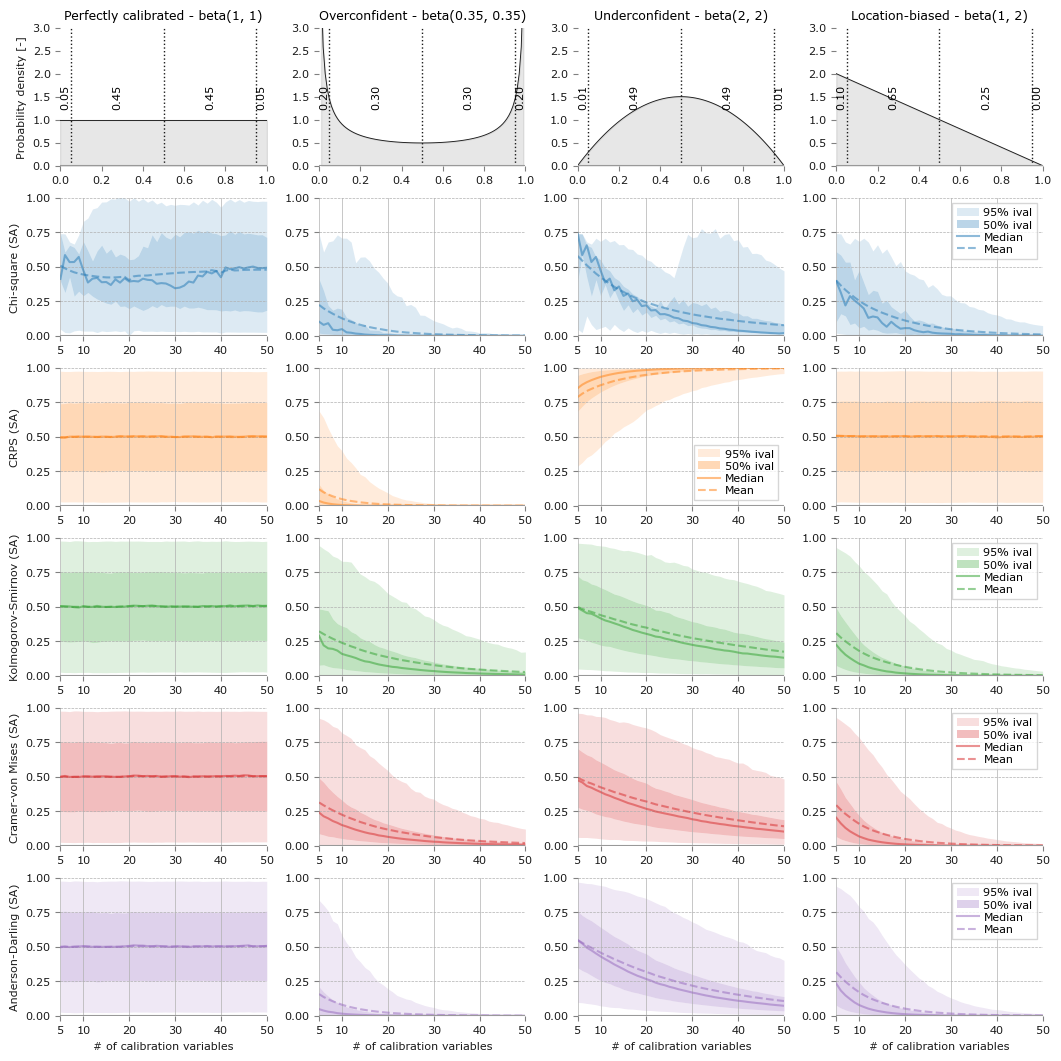

In [12]:
fig = plt.figure(figsize=(10.5, 10.5), constrained_layout=True)

for j, name in enumerate(experts.keys()):
    # Add betaplot
    ax = plt.subplot2grid((len(sa_methods) + 1, len(experts)), (0, j), rowspan=1, colspan=1, fig=fig)
    add_beta_plot(name, ax)
    if j == 0:
        ax.set_ylabel("Probability density [-]")

for i, method in enumerate(sa_methods):

    method_res = sa_scores[method.value]

    for j, (name, cali_res) in enumerate(method_res.items()):

        # Add other plots
        axrow = [
            plt.subplot2grid((len(sa_methods) + 1, len(experts)), (i + 1, j), fig=fig),
        ]

        for ax in axrow:

            vals = np.array(cali_res)[:, offset:]
            
            ax.fill_between(
                npoints,
                *np.percentile(vals, [2.5, 25], axis=0),
                alpha=0.15,
                label="95% ival",
                color=f"C{i}",
                lw=0,
            )
            ax.fill_between(
                npoints,
                *np.percentile(vals, [25, 75], axis=0),
                alpha=0.3,
                label="50% ival",
                color=f"C{i}",
                lw=0,
            )
            ax.fill_between(
                npoints, *np.percentile(vals, [75, 97.5], axis=0), alpha=0.15, color=f"C{i}", lw=0
            )
            ax.plot(npoints, *np.percentile(vals, [50], axis=0), alpha=0.5, label="Median", color=f"C{i}")
            ax.plot(npoints, np.mean(vals, axis=0), alpha=0.5, label="Mean", color=f"C{i}", ls="--")
            ax.grid(axis="x", ls="-")
            ax.grid(axis="y", ls="--")
            ax.set(
                xlim=(minN + offset, 50), xticks=[minN + offset, 10, 20, 30, 40, 50], ylim=(0, 1), yticks=[0, 0.25, 0.5, 0.75, 1.0]
            )
            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.axhline(0.0, color=".6", ls="-")

        if j == 2 and method == CalibrationMethod.CRPS:
            axrow[0].legend(loc="lower right")
        elif j == 3 and method != CalibrationMethod.CRPS:
            axrow[0].legend(loc="upper right")

        #         axrow[0].set_ylim(0, 1)
        axrow[0].set_ylabel(method.value + " (SA)" if j == 0 else None)
#         axrow[1].set_yscale('log')
#         axrow[1].set_ylim(1e-4, 1)

        if i == 4:
            ax.set_xlabel('# of calibration variables')

# fig.tight_layout()


fig.savefig("./figures/sampling_res_linear.pdf", bbox_inches="tight", pad_inches=0.001)

In [23]:
np.shape(cali_res)

(2000, 48)

In [27]:

cali_res[:][offset:]

[[0.8080360827085954,
  0.8391845754431135,
  0.7398549479922584,
  0.7376210947869171,
  0.6552262692537625,
  0.6401024609620303,
  0.5707831185329525,
  0.47350087928328943,
  0.49196777391587565,
  0.41314560863290783,
  0.4208117950003021,
  0.3565378397846697,
  0.2879975855605156,
  0.3052566285370133,
  0.30291586137478665,
  0.28470389861143586,
  0.25544270400599867,
  0.23922206710966765,
  0.21473125340511945,
  0.20048709988579205,
  0.18002558642187183,
  0.15609960460306926,
  0.13112934611803428,
  0.10700467896606636,
  0.08501977446574926,
  0.06590825703908398,
  0.2133912033204517,
  0.1688808553166501,
  0.19629893043214897,
  0.1564935246026269,
  0.12210025106474987,
  0.09335571937269072,
  0.11286979762287286,
  0.08701166787990355,
  0.10337405333127458,
  0.08027846865967714,
  0.10166735363519708,
  0.4149246232591841,
  0.3392632796377062,
  0.2933226608610817,
  0.36673078164804407,
  0.24975804132670087,
  0.21104788380763972,
  0.26615256205574545,
  0.3